# AVISO Inversion with all data and swath data, no error

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, build_h_matrix
from aviso_rossby_wave import reverse_vector, forecast_ssh
from aviso_rossby_wave import inversion, build_swath

## Starting Date

In [2]:
day0, day1 = 0, 5 # 2016-06-01
time_range = (day1 - day0) * 2
start_date = '2016-09-01' ## starting date
n_waves = '380' #number of waves
exp = 1 # R_over_P = K^-1

## Subset 10 degree by 10 degree of ocean

In [3]:
lonidx_west, lonidx_east = 67, 107
latidx_south, latidx_north = 22, 62

In [4]:
aviso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')
SSHA = aviso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]

In [5]:
T_time = aviso_ds.time.data[day0:] * 86400
date_time = aviso_ds.date_time.data[day0:]
date_time[0]

numpy.datetime64('2016-01-01T00:00:00.000000000')

In [6]:
ssha_time_mean = SSHA.mean(axis = -1)

In [7]:
SSHA = SSHA - SSHA.mean(axis = -1) #- SSHA.mean(axis = 0)

In [8]:
SSHA_masked = np.ma.masked_invalid(SSHA)

In [9]:
ssha_mask = np.ma.getmask(SSHA_masked)

In [10]:
lon, lat = (360 - aviso_ds.lon[lonidx_west:lonidx_east].data) * -1, aviso_ds.lat[latidx_south:latidx_north].data

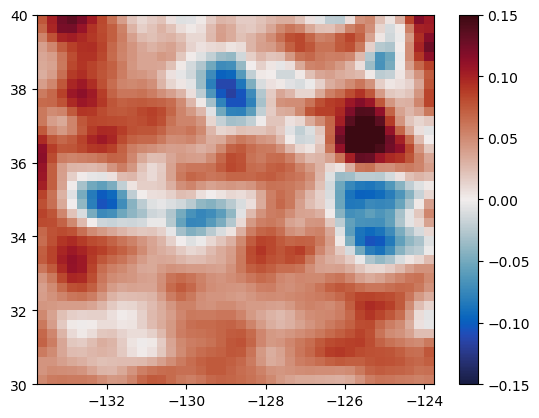

In [11]:
plt.pcolormesh(lon, lat, SSHA[:, :, 0], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
plt.colorbar()

#### Rossby wave vertical modes

In [12]:
MModes = 1

### Inversion with selecetd swath data points

In [13]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

### parameters

In [14]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

In [15]:
Psi = strat_ds.Psi.data


### the aviso data is sampled at 5-day intervals

In [16]:
#selected_time = 12 #(day1 - day0) * 2 + 1 #12 # 5 * 8 = 40 days

#### Rossby wave estimate

In [17]:
# wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date + '_' + n_waves + 'waves.nc')
wave_ds =  xr.open_dataset('rossby_wave_estimate_2016-01-01_190waves_data5days.nc')

In [18]:
l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree

In [19]:
l_n = l_n_orig.reshape(len(l_n_orig), MModes)
k_n = k_n_orig.reshape(len(k_n_orig), MModes)

#### !!! fix the indexing of forward model: day0, day1

In [20]:
MSLA_train = wave_ds.MSLA_forward.data[:, :, day0:day1]

In [21]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA_train, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)

#### Number of models/waves

In [22]:
M = k_n.size * l_n.size

#### Plot skill matrix

In [23]:
kk, ll = np.meshgrid(k_n, l_n)

#### Build basis function H matrix

In [24]:
    dlon = lon - lon.mean()
    dlat = lat - lat.mean()
    
    H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
    H_all = np.zeros([len(SSHA_vector), M*2])
    omega = np.zeros([len(k_n), len(l_n), MModes])

    nn = 0 
    for kk in range(len(k_n)):
        for ll in range(len(l_n)):
            for mm in range(MModes):
                omega[kk, ll, mm] =   (Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)
                for count in range(len(Iindex)):
                    H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] + omega[kk, ll, mm] * T_time[int(Tindex[count])]) 
                    H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] + omega[kk, ll, mm] * T_time[int(Tindex[count])])
                nn += 1

    H_all[:, 0::2] = H_cos 
    H_all[:, 1::2] = H_sin
    H_all1 = H_all

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_1660/1247574536.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  omega[kk, ll, mm] =   (Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)


#### Use the same signal to noise ratio as the forward model

#### signal to noise ratio

Signal to noise ratio decreases in proportion to $k^{-2}$

In [25]:
counter = 0
kl, P_over_R = np.zeros(2 * M), np.zeros([2 * M, 2 * M])
for kk in l_n:
    for ll in k_n:
        kl[2*counter] = np.sqrt(kk ** 2 + ll ** 2)
        kl[2*counter+1] = np.sqrt(kk ** 2 + ll ** 2)
        P_over_R[2*counter, 2*counter] = kl[2*counter] ** exp
        P_over_R[2*counter+1, 2*counter+1] = kl[2*counter + 1] ** exp
        counter += 1
        

/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_1660/628074473.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[2*counter] = np.sqrt(kk ** 2 + ll ** 2)
/var/folders/tb/ynf00vf51q52gx0ngbt970v00000gn/T/ipykernel_1660/628074473.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[2*counter+1] = np.sqrt(kk ** 2 + ll ** 2)


#### solve for amplitudes with all data

In [26]:
H_all = build_h_matrix(MSLA_train, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day0-day0)
amp_all_data, ssh_estimated = inversion(SSHA_vector, H_all, P_over_R)

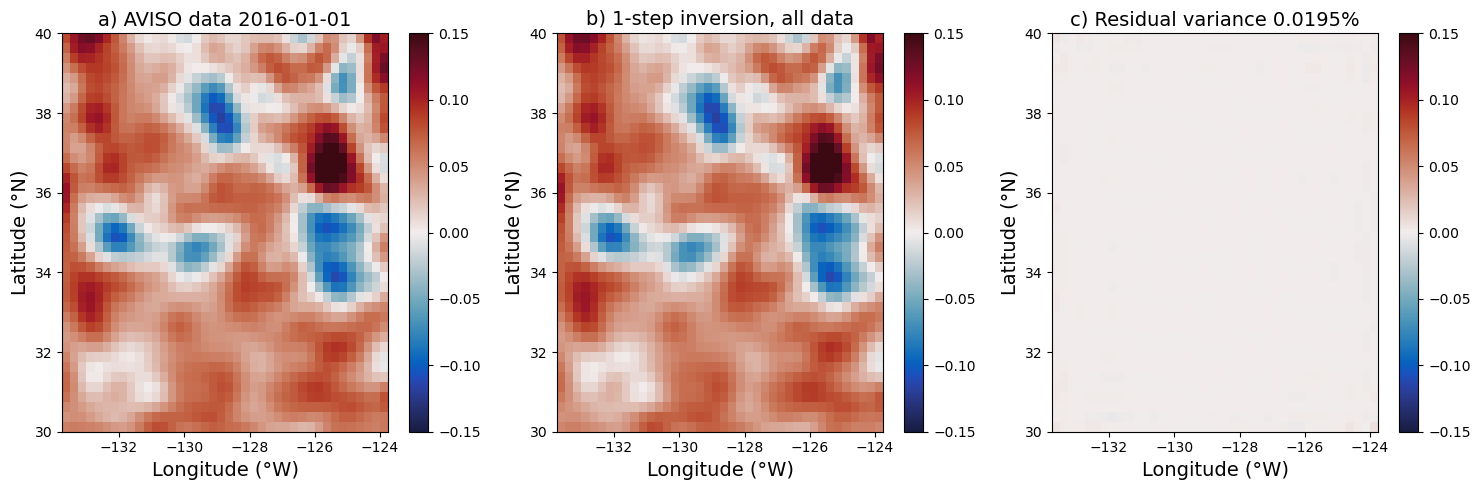

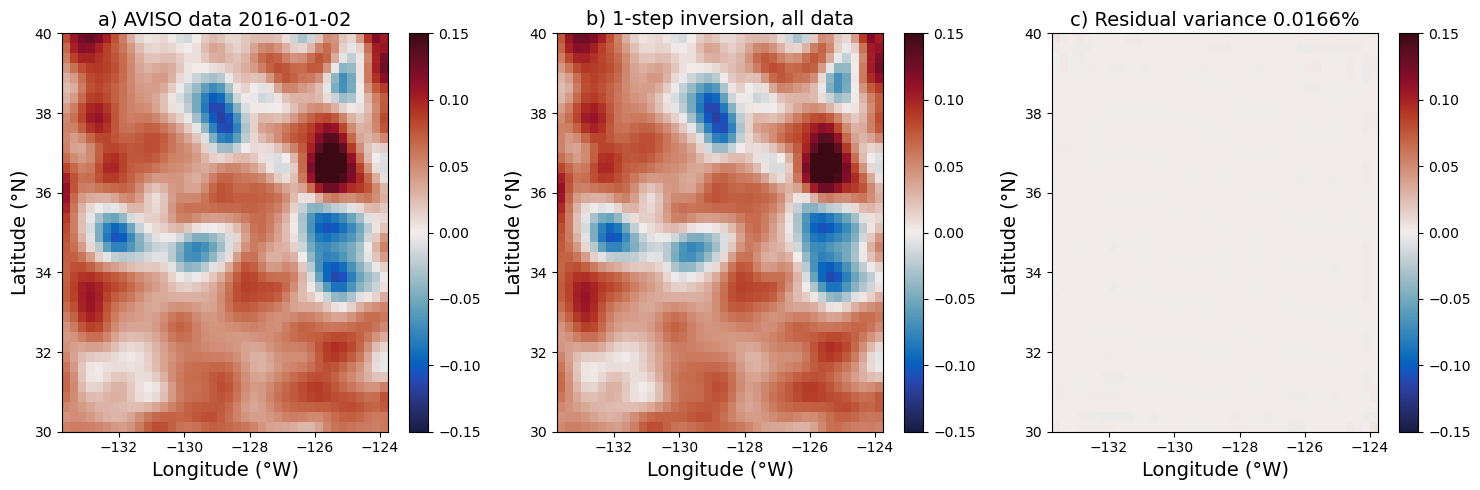

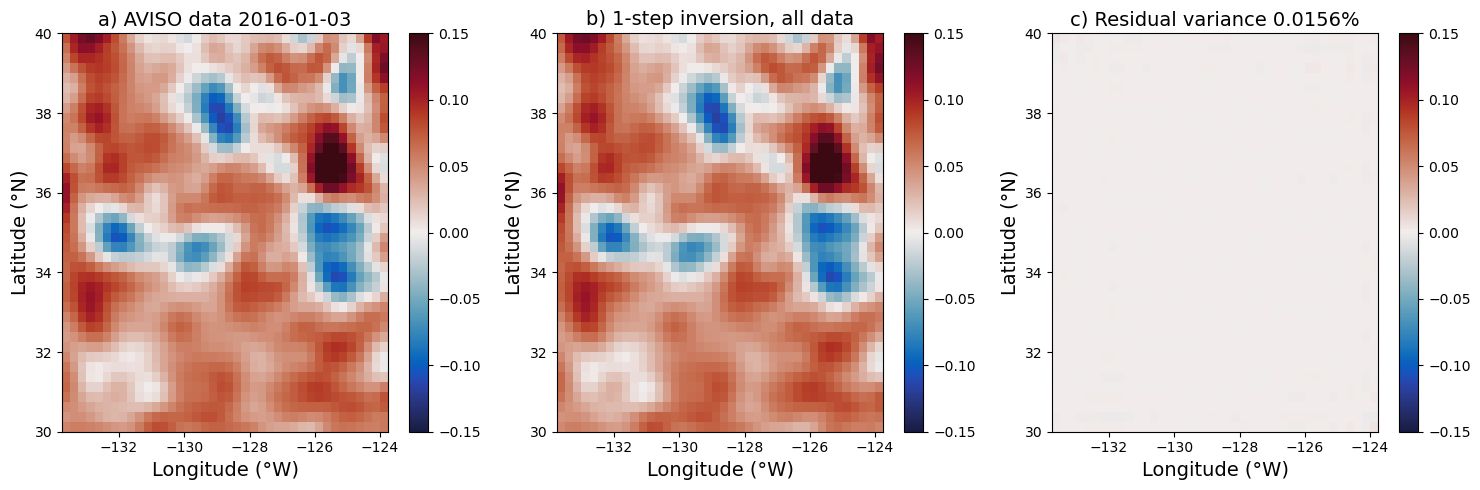

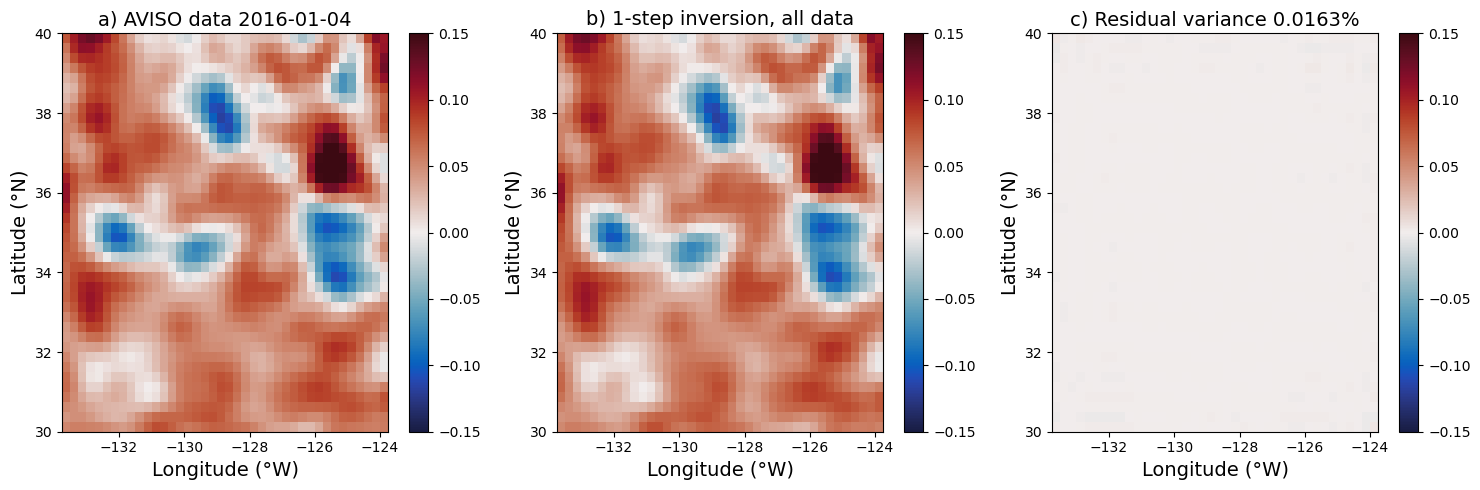

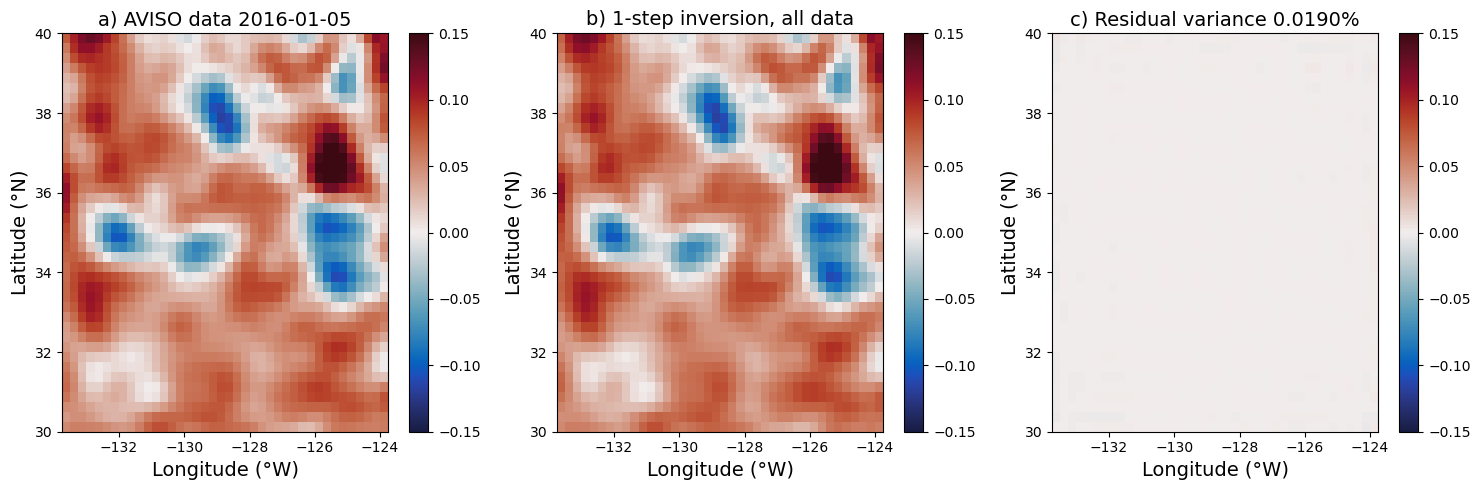

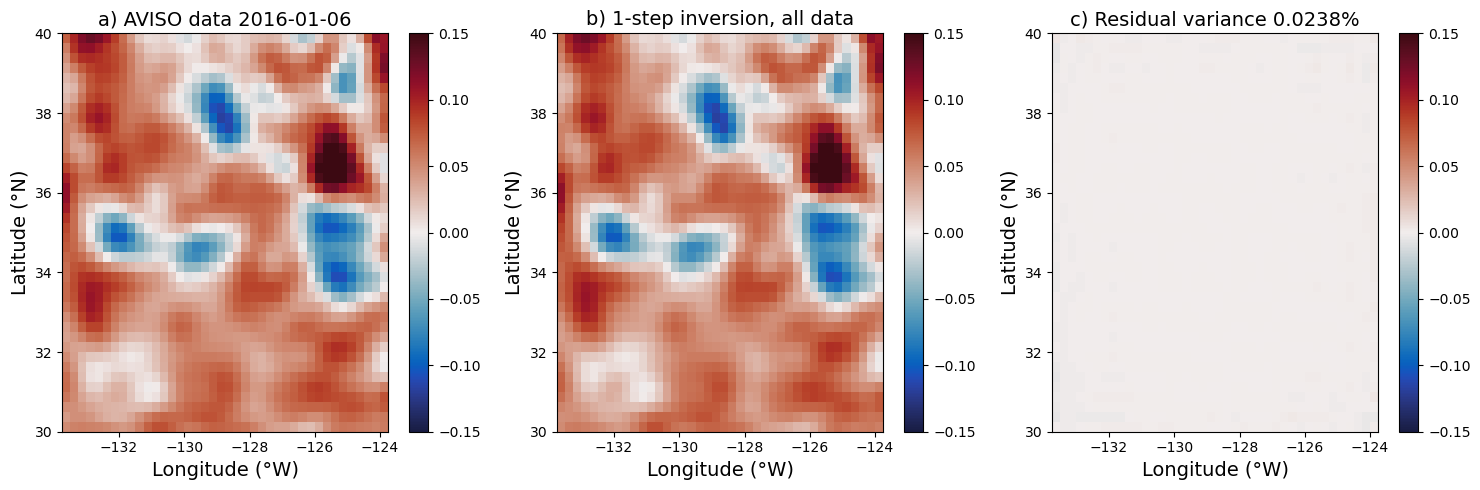

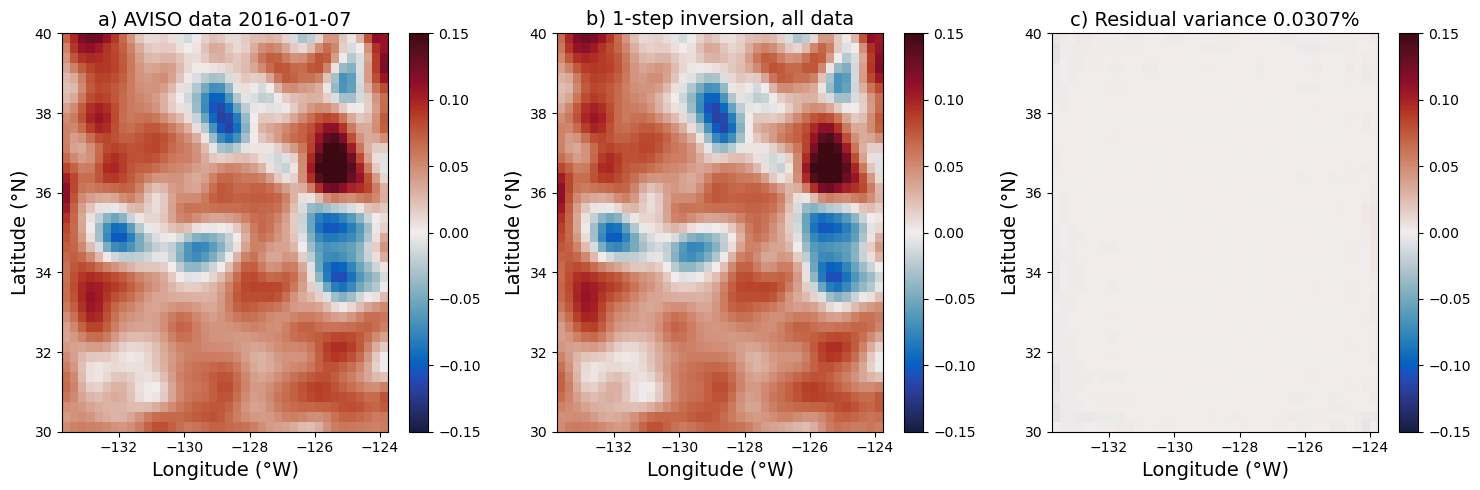

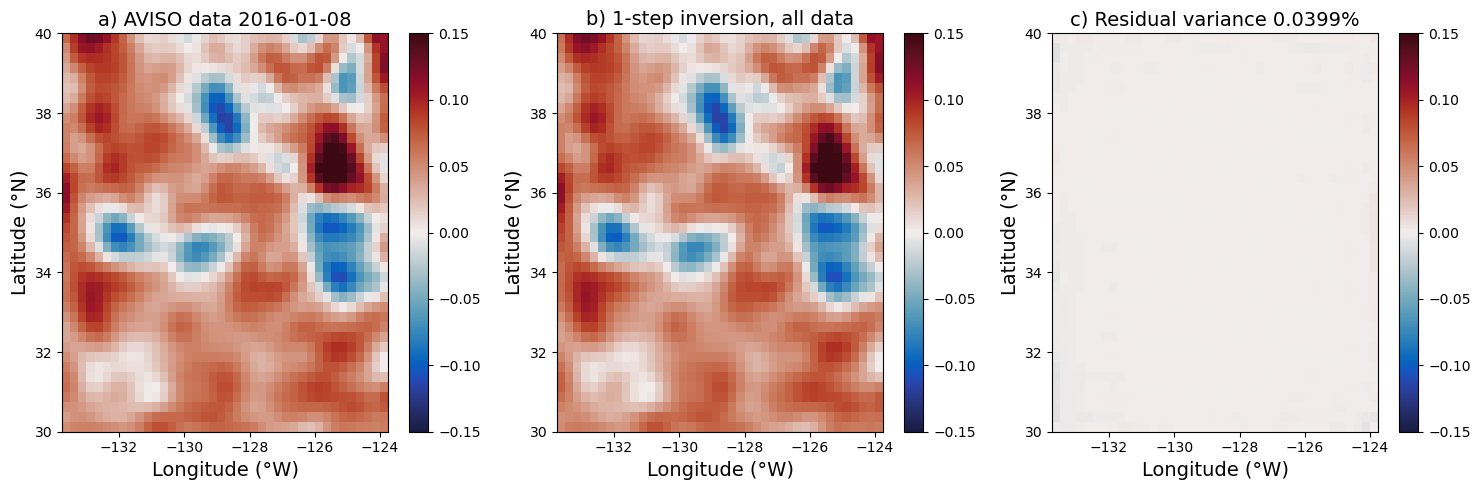

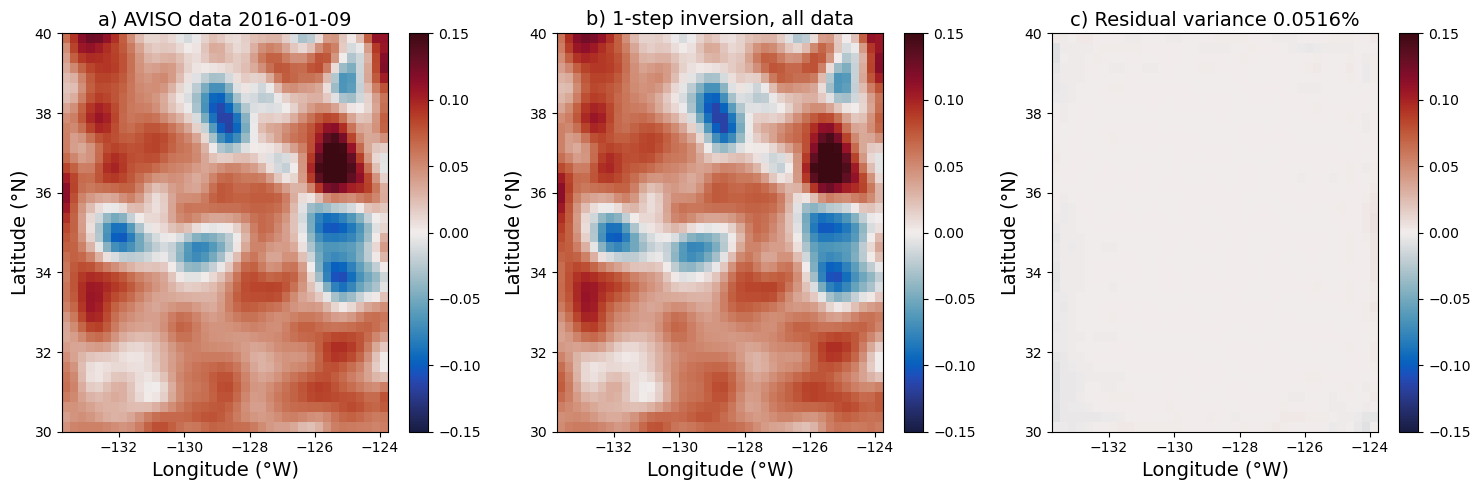

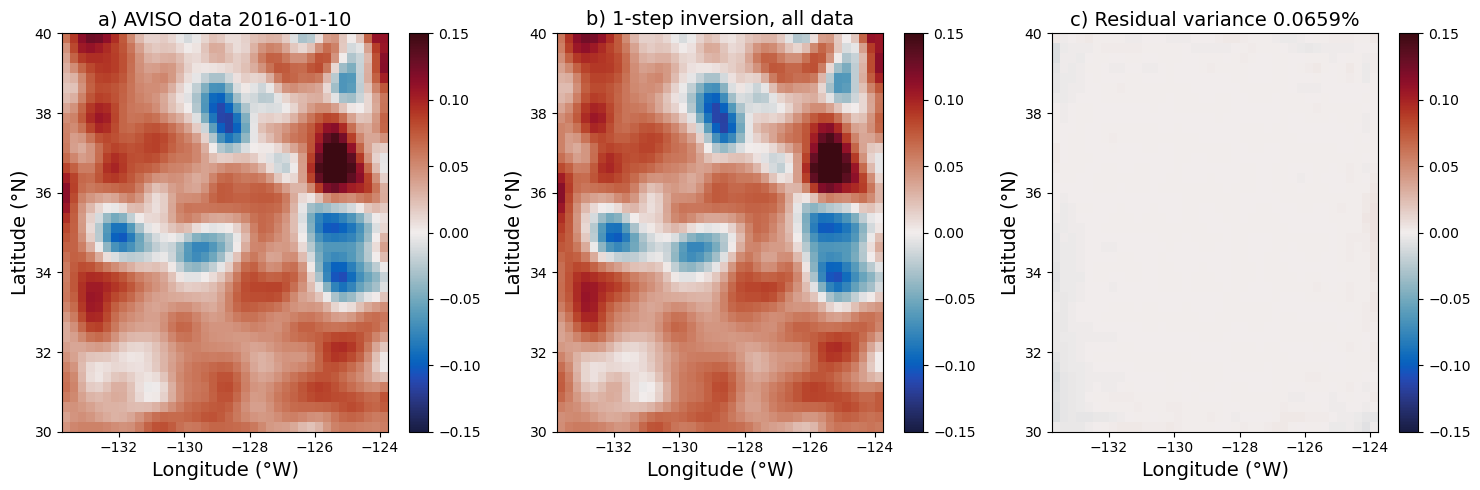

In [27]:
SSHA_predicted = np.zeros([time_range, MSLA_train[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA_train[:, :, 0:1].size])
residual_variance = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA_train.shape[0], MSLA_train.shape[1], time_range])
for day in range(time_range):
    MSLA = MSLA_fwd[:, :, day:day+1]
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day0 - day0 + day)
    SSHA_predicted[day], SSHA_true[day], residual_variance[day] = forecast_ssh(MSLA, amp_all_data, H_all)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO data ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 1-step inversion, all data', fontsize = 14)

    residual =  MSLA[:, :, 0] - MSLA_inverse[:, :, day] 
    plt.subplot(133)
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((residual_variance[day]) * 100)[:6] + '%', fontsize = 14)

    plt.tight_layout()
    #plt.close()
    # plt.savefig('./inversion/inversion_' + str(date_time[day])[:10] +'_all_data_' + str(skill.size) + 'waves_1step.png', dpi = 100)

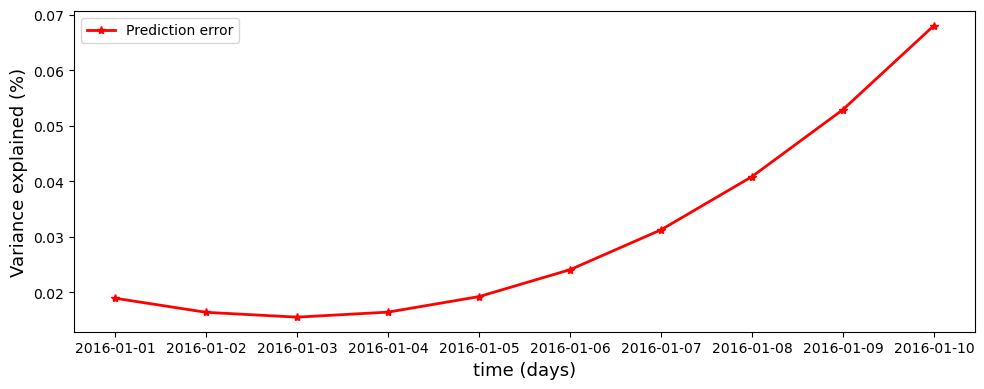

In [28]:
# perfect data are predicted perfectly with a perfect model.....
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
prediction_err = MSLA_inverse[:, :, :time_range] - MSLA_fwd[:, :, :time_range]
var_persistence = np.zeros(persistence.shape[-1])
var_prediction_err = np.zeros(prediction_err.shape[-1])
for t in range(persistence.shape[-1]):
    var_persistence[t] = (np.mean(persistence[:, :, t] ** 2)) / (np.mean(SSHA[:, :, 0:1].data ** 2))
    var_prediction_err[t] = (np.mean(prediction_err[:, :, t] ** 2)) / (np.mean(SSHA[:, :, t].data ** 2))

plt.figure(figsize = (10,4))
plt.plot(time[:time_range][:],  var_prediction_err[:time_range][:] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Prediction error')
# plt.plot(time[:time_range][:],  var_persistence[:time_range][:] * 100,  
#          '-o',linewidth = 2, color = 'b', label = 'Persistence')
plt.ylabel('Variance explained (%)', fontsize = 13)
plt.xlabel('time (days)', fontsize = 13)
plt.legend()
plt.tight_layout()
# plt.savefig('./prediction_vs_persistence/all_data_prediction_err_' + str(M) + '_waves.png', dpi = 300)

#### build satellite swath

In [29]:
swot_ds = xr.open_dataset('./swot_L2.nc')

In [30]:
# Assuming swot_ds is your dataset
# Extract the nadir position for the ground track
swot_latitude = swot_ds['latitude'].values
swot_longitude = swot_ds['longitude'].values

In [31]:
def build_swath(msla, lon, lat, swot_longitude, swot_latitude, days):
    
    import numpy as np

    # Define the bounds for the California Current System (CCS)
    cc_bounds = {
        "lon": [360-135, 360-120],
        "lat": [30, 43]
    }

    # Filter SWOT data points within the CCS bounds
    valid_swot_mask = (swot_latitude >= cc_bounds["lat"][0]) & (swot_latitude <= cc_bounds["lat"][1]) & \
                      (swot_longitude >= cc_bounds["lon"][0]) & (swot_longitude <= cc_bounds["lon"][1])
    swot_longitude = swot_longitude[valid_swot_mask]
    swot_latitude = swot_latitude[valid_swot_mask]

    # Find bounding rectangle for SWOT data
    min_lon, max_lon = np.min(swot_longitude), np.max(swot_longitude)
    min_lat, max_lat = np.min(swot_latitude), np.max(swot_latitude)

    # Generate a meshgrid from the lon and lat arrays
    LON, LAT = np.meshgrid(lon, lat)
    
    # Identify the SWOT points that intersect the CCS bounds
    intersect_mask = (
        (swot_latitude >= cc_bounds["lat"][0]) & (swot_latitude <= cc_bounds["lat"][1]) & 
        (swot_longitude >= cc_bounds["lon"][0]) & (swot_longitude <= cc_bounds["lon"][1])
    )

    intersected_lons = swot_longitude[intersect_mask]
    intersected_lats = swot_latitude[intersect_mask]
    
    # For the purpose of demonstration, I will use a simple nearest neighbor interpolation on the AVISO grid
    # This approach might not be the best depending on your data distribution, so consider other interpolation techniques if needed.
    msla_interpolated = np.ones_like(msla) * 1e20
    
    for s_lon, s_lat in zip(intersected_lons, intersected_lats):
        nearest_lon_idx = np.abs(lon - s_lon).argmin()
        nearest_lat_idx = np.abs(lat - s_lat).argmin()
        
        msla_interpolated[nearest_lat_idx, nearest_lon_idx] = msla[nearest_lat_idx, nearest_lon_idx]
        
    msla_interpolated = np.ma.masked_equal(msla_interpolated, 1e20)

    # Generate an X-shaped mask
    mask_upper_left = np.logical_and(LON < (min_lon + max_lon) / 2, LAT > (min_lat + max_lat) / 2)
    mask_upper_right = np.logical_and(LON > (min_lon + max_lon) / 2, LAT > (min_lat + max_lat) / 2)
    mask_lower_left = np.logical_and(LON < (min_lon + max_lon) / 2, LAT < (min_lat + max_lat) / 2)
    mask_lower_right = np.logical_and(LON > (min_lon + max_lon) / 2, LAT < (min_lat + max_lat) / 2)
    
    diagonal_mask_1 = (LAT - min_lat) / (max_lat - min_lat) > (LON - min_lon) / (max_lon - min_lon)
    diagonal_mask_2 = (LAT - min_lat) / (max_lat - min_lat) < (LON - min_lon) / (max_lon - min_lon)

    mask_left = mask_upper_left * diagonal_mask_1 + mask_lower_left * diagonal_mask_2
    mask_right = mask_upper_right * diagonal_mask_2 + mask_lower_right * diagonal_mask_1

    yswath_index_left = np.ma.masked_where(~mask_left, LAT)
    xswath_index_left = np.ma.masked_where(~mask_left, LON)
    
    yswath_index_right = np.ma.masked_where(~mask_right, LAT)
    xswath_index_right = np.ma.masked_where(~mask_right, LON)
    
    # Creating the xindex, yindex, tindex arrays
    yvalid_index = np.append(yswath_index_left.compressed(), yswath_index_right.compressed()) 
    xvalid_index = np.append(xswath_index_left.compressed(), xswath_index_right.compressed())
    
    tindex, xindex, yindex = [], [], []
    xindex =  np.tile(xvalid_index, len(days))
    yindex =  np.tile(yvalid_index, len(days))
    
    for dd in days:
        tmp = np.tile(dd, len(yvalid_index))
        tindex = np.append(tindex, tmp)
        # Convert masked longitude and latitude values to indices
    yvalid_indices = np.where(np.logical_or(mask_left, mask_right))
    yvalid_index = yvalid_indices[0]
    xvalid_index = yvalid_indices[1]

    # Creating the xindex, yindex, tindex arrays
    tindex = np.array([dd for dd in days for _ in range(len(yvalid_index))])

    return xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, mask_left, mask_right, msla_interpolated

In [32]:
def build_swath(msla, lon, lat, swot_longitude, swot_latitude, days):
    import numpy as np

    # Define the bounds for the California Current System (CCS)
    cc_bounds = {
        "lon": [360-135, 360-120],
        "lat": [30, 43]
    }

    # Filter SWOT data points within the CCS bounds
    valid_swot_mask = (swot_latitude >= cc_bounds["lat"][0]) & (swot_latitude <= cc_bounds["lat"][1]) & \
                      (swot_longitude >= cc_bounds["lon"][0]) & (swot_longitude <= cc_bounds["lon"][1])
    swot_longitude = swot_longitude[valid_swot_mask]
    swot_latitude = swot_latitude[valid_swot_mask]
    
        # Identify the SWOT points that intersect the CCS bounds
    intersect_mask = (
        (swot_latitude >= cc_bounds["lat"][0]) & (swot_latitude <= cc_bounds["lat"][1]) & 
        (swot_longitude >= cc_bounds["lon"][0]) & (swot_longitude <= cc_bounds["lon"][1])
    )
    
    intersected_lons = swot_longitude[intersect_mask]
    intersected_lats = swot_latitude[intersect_mask]
    
    # For the purpose of demonstration, I will use a simple nearest neighbor interpolation on the AVISO grid
    # This approach might not be the best depending on your data distribution, so consider other interpolation techniques if needed.
    msla_interpolated = np.ones_like(msla) * 1e20
    
    for s_lon, s_lat in zip(intersected_lons, intersected_lats):
        nearest_lon_idx = np.abs(lon - s_lon).argmin()
        nearest_lat_idx = np.abs(lat - s_lat).argmin()
        
        msla_interpolated[nearest_lat_idx, nearest_lon_idx] = msla[nearest_lat_idx, nearest_lon_idx]
        
    msla_interpolated = np.ma.masked_equal(msla_interpolated, 1e20)

    # Find bounding rectangle for SWOT data
    min_lon, max_lon = np.min(swot_longitude), np.max(swot_longitude)
    min_lat, max_lat = np.min(swot_latitude), np.max(swot_latitude)

    # Generate a meshgrid from the lon and lat arrays
    LON, LAT = np.meshgrid(lon, lat)

    # Generate an X-shaped mask
    mask_upper_left = np.logical_and(LON < (min_lon + max_lon) / 2, LAT > (min_lat + max_lat) / 2)
    mask_upper_right = np.logical_and(LON > (min_lon + max_lon) / 2, LAT > (min_lat + max_lat) / 2)
    mask_lower_left = np.logical_and(LON < (min_lon + max_lon) / 2, LAT < (min_lat + max_lat) / 2)
    mask_lower_right = np.logical_and(LON > (min_lon + max_lon) / 2, LAT < (min_lat + max_lat) / 2)

    diagonal_mask_1 = (LAT - min_lat) / (max_lat - min_lat) > (LON - min_lon) / (max_lon - min_lon)
    diagonal_mask_2 = (LAT - min_lat) / (max_lat - min_lat) < (LON - min_lon) / (max_lon - min_lon)

    mask_left = mask_upper_left * diagonal_mask_1 + mask_lower_left * diagonal_mask_2
    mask_right = mask_upper_right * diagonal_mask_2 + mask_lower_right * diagonal_mask_1

    yswath_index_left = np.ma.masked_where(~mask_left, LAT)
    xswath_index_left = np.ma.masked_where(~mask_left, LON)
    
    yswath_index_right = np.ma.masked_where(~mask_right, LAT)
    xswath_index_right = np.ma.masked_where(~mask_right, LON)

    # Extract indices for left and right
    yvalid_indices_left = np.where(mask_left)
    xvalid_indices_left = yvalid_indices_left[1]
    yvalid_indices_right = np.where(mask_right)
    xvalid_indices_right = yvalid_indices_right[1]

    # For tindex, based on the number of days
    tindex_left = np.array([dd for dd in days for _ in range(len(yvalid_indices_left[0]))])
    tindex_right = np.array([dd for dd in days for _ in range(len(yvalid_indices_right[0]))])

    # Combine left and right indices for output
    xvalid_index = np.concatenate([xvalid_indices_left, xvalid_indices_right])
    yvalid_index = np.concatenate([yvalid_indices_left[0], yvalid_indices_right[0]])
    tindex = np.concatenate([tindex_left, tindex_right])

    return xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, mask_left, mask_right


In [33]:
days= np.arange(day0, day1)
aviso_lon, aviso_lat = aviso_ds.lon.data[lonidx_west:lonidx_east], aviso_ds.lat.data[latidx_south:latidx_north]

In [34]:
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, mask_left, mask_right = build_swath(MSLA_train[:, :,0:1].reshape(40, 40), aviso_lon, aviso_lat, swot_longitude, swot_latitude, days)

In [35]:
plt.pcolormesh(lon, lat, msla_filtered[:])

NameError: name 'msla_filtered' is not defined

In [ ]:
# Build an H_swath matrix for a single snapshot; 
# this is nearly underdetermined but should produce a perfect fit within the swaths
N = len(xvalid_index) # number of data
MSLA_swath = np.zeros(len(xvalid_index))
mask=np.zeros([MSLA_fwd.shape[0],MSLA_fwd.shape[1]])
M = l_n.size * k_n.size
nx, ny = len(lon), len(lat)
H_swath = np.zeros([N, 2 * M]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
MSLA_swath = np.zeros(N)
ssh = np.zeros(N)
for ii in range(len(xvalid_index)):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    ssh[ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])]
    mask[yvalid_index[ii], xvalid_index[ii]]=1
    MSLA_swath[ii] = ssh[ii]  #+ cor_err[ii] 
    for nn in range(M):
        JIndex = 2 * MModes * nn # Model space
        H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]
        

#### Solve for amplitudes

In [ ]:
amp_swath, ssh_estimated_swath = inversion(MSLA_swath, H_swath, P_over_R)

#### Reverse the vectorization on the swaths

In [ ]:
ssh_true = np.zeros([len(lat), len(lon)])
ssh_map = np.zeros([len(lat), len(lon)])

In [ ]:
for ii in range(len(xvalid_index)):
    ssh_map[yvalid_index[ii], xvalid_index[ii]] = ssh_estimated_swath[ii]
    ssh_true[yvalid_index[ii], xvalid_index[ii]] = MSLA_swath[ii]


In [ ]:
ssh_diff = (np.mean((ssh_true - ssh_map) ** 2 ))/ (np.mean((ssh_true) ** 2 ))

In [ ]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_map, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true - ssh_map, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff * 100)[:4] + '%', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+str(time[day])[:10] + '_no_error.png')

In [ ]:
H_swath1 = H_swath

In [ ]:
# Build an H_swath matrix for a series of snapshots
N = len(xvalid_index) # number of data
Ndata=N*int(day1-day0)
MSLA_swath = np.zeros(len(xvalid_index))
M = l_n.size * k_n.size
nx, ny = len(lon), len(lat)
H_swath = np.zeros([Ndata, 2 * M]) # M: number of model
IIndex = np.zeros(Ndata) # N: Number of y data
cor_err = np.zeros(Ndata) # Correlated Error N: Number of y data
MSLA_swath = np.zeros(Ndata)
ssh = np.zeros(Ndata)
for tt in range(day1-day0):
    for ii in range(N):
        index=nx * yvalid_index[ii] + xvalid_index[ii] + tt*nx*ny
        ssh[tt*N+ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])+tt]
        MSLA_swath[tt*N+ii] = ssh[tt*N+ii]  #+ cor_err[ii]
        H_swath[tt*N+ii,:]=H_all1[int(index),:]

In [ ]:
amp_swath1, ssh_estimated_swath1 = inversion(MSLA_swath[0:450], H_swath[0:450,:], P_over_R)

In [ ]:
amp_swath1a, ssh_estimated_swath1a = inversion(MSLA_swath[0:450], H_swath1[0:450,:], P_over_R)

In [ ]:
amp_swath10, ssh_estimated_swath10 = inversion(MSLA_swath, H_swath, P_over_R)

In [ ]:
forecast_swath = np.matmul(H_swath, amp_swath10)
forecast_total = np.matmul(H_all1, amp_swath10)
forecast_correct = np.matmul(H_all1, amp_all_data)

In [ ]:
ssh_true10 = np.zeros([len(lat), len(lon), time_range])
ssh_map10 = np.zeros([len(lat), len(lon), time_range])
ssh_forecast10 = np.zeros([len(lat), len(lon),time_range])
ssh_forecast_total = np.zeros([len(lat), len(lon),time_range])
ssh_forecast_correct = np.zeros([len(lat), len(lon),time_range])
ssh_forecast_total = np.reshape(forecast_total,[time_range, len(lat), len(lon)]).transpose(1,2,0)
ssh_forecast_correct = np.reshape(forecast_correct,[time_range, len(lat), len(lon)]).transpose(1,2,0)
for tt in range(day1-day0):
    for ii, idx in enumerate(xvalid_index):
        ssh_map10[yvalid_index[ii], xvalid_index[ii],tt]  = ssh_estimated_swath10[ii+tt*N]
        ssh_true10[yvalid_index[ii], xvalid_index[ii],tt] = MSLA_swath[ii+tt*N]
        ssh_forecast10[yvalid_index[ii], xvalid_index[ii],tt] = forecast_swath[ii+tt*N]

In [ ]:
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolor(ssh_map10[:,:,9]-ssh_forecast_total[:,:,9], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
    
    plt.subplot(132)
    plt.pcolor(ssh_forecast10[:,:,0]-ssh_forecast_total[:,:,0], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
    
    plt.subplot(133)
    plt.pcolor(ssh_true10[:,:,9]-ssh_forecast_correct[:,:,9], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)

In [ ]:
variance_on_track=np.zeros(int(day1-day0))
for i in range(int(day1-day0)):
    variance_on_track[i]=np.mean((ssh_estimated_swath10[N*i:N*(i+1)]-MSLA_swath[N*i:N*(i+1)])**2)/np.mean((MSLA_swath[N*i:N*(i+1)])**2)

In [ ]:
plt.plot(variance_on_track)

In [ ]:
plt.plot(ssh_estimated_swath10[0:N])
plt.plot(ssh_estimated_swath10[N:2*N])
plt.plot(ssh[0:N])
plt.plot(ssh[N:2*N])

#### Make predictions of SSH based on the estimated amplitudes:
#### Swath data, no errors

In [ ]:
SSHA_predicted = np.zeros([time_range, MSLA_train[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA_train[:, :, 0:1].size])
residual_variance = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA_train.shape[0], MSLA_train.shape[1], time_range])

for day in range(0, time_range):
#for day in range(2):
    MSLA = MSLA_fwd[:, :, day:day+1] 
    # new H matrix over time
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day-0)
    # forecast SSH
    SSHA_predicted[day], SSHA_true[day], residual_variance[day] = forecast_ssh(MSLA, amp_swath10, H_all) 
    #SSHA_predicted[day], SSHA_true[day], residual_variance[day] = forecast_ssh(MSLA, amp_swath1, H_all) 
    #SSHA_predicted[day], SSHA_true[day], residual_variance[day] = forecast_ssh(MSLA, amp_all_data, H_all) 
    # reshape the 1-dimensional SSH array to 2-dimensional
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 1-step inversion, swath data', fontsize = 14)
    
    residual = MSLA[:, :, 0] - MSLA_inverse[:, :, day]
    plt.subplot(133)
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.plot(lon[xvalid_index], lat[yvalid_index], '.', color = 'gray')
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((residual_variance[day]) * 100)[:4] + '%', fontsize = 14)
    
    plt.tight_layout()
    #plt.close()
    plt.savefig('./swath/swath_' + str(date_time[day0 + day])[:10] +'_no_err_' + str(skill.size) + 'waves_with_swath.png', dpi = 100)

In [ ]:
MSLA.shape, MSLA_inverse.shape, SSHA_predicted.shape, SSHA_true.shape, MSLA_fwd.shape
msla_in=np.ma.masked_where(mask==0,MSLA_inverse[:,:,0])
msla_out=np.ma.masked_where(mask==1,MSLA_inverse[:,:,0])
var_in=np.zeros(20)
var_out=np.zeros(20)
for i in range(20):
    msla_in=np.ma.masked_where(mask==0,MSLA_fwd[:,:,i])
    msla_out=np.ma.masked_where(mask==1,MSLA_fwd[:,:,i])
    var_in[i]=np.mean(np.mean((MSLA_inverse[:,:,i]-msla_in)**2,axis=1),axis=0)/(np.mean(np.mean(msla_in**2,axis=1),axis=0))
    var_out[i]=np.mean(np.mean((MSLA_inverse[:,:,i]-msla_out)**2,axis=1),axis=0)/(np.mean(np.mean(msla_out**2,axis=1),axis=0))

In [ ]:
# plt.pcolor(msla_out)

In [ ]:
plt.figure(figsize = (10,2))
plt.plot(time[:20], np.mean(np.mean((MSLA_inverse-MSLA_fwd[:,:,0:20])**2,axis=1),axis=0)/np.mean(np.mean((MSLA_fwd[:,:,0:20])**2,axis=1),axis=0),label='overall variance')
plt.plot(time[:20],var_in,label = 'variance within swath')
plt.plot(time[:20],var_out,label='variance outside swath')
plt.plot(time[:10],variance_on_track,label='variance in simple solution')
plt.ylabel('Residual fractional variance', fontsize = 13)
plt.xlabel('time', fontsize = 13)
plt.legend()

In [ ]:
plt.plot(time[:10],variance_on_track,label='variance in simple solution')
plt.plot(time[:10],var_in[:10],label = 'variance within swath')

In [ ]:
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
persistence0 = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
persistence1 = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day1:day1+1]
daym=int((day0+day1)/2)
persistencem = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, daym:daym+1]
prediction_err = MSLA_inverse[:, :, :time_range] - MSLA_fwd[:, :, :time_range]
var_persistence = np.zeros(persistence.shape[-1])
var_persistence0 = np.zeros(persistence0.shape[-1])
var_persistence1 = np.zeros(persistence1.shape[-1])
var_persistencem = np.zeros(persistence1.shape[-1])
var_prediction_err = np.zeros(prediction_err.shape[-1])

for t in range(persistence.shape[-1]):
    # normalize the error/persistence 
    var_persistence0[t] = (np.mean(persistence0[:, :, t] ** 2)) / (np.mean(SSHA[:, :, day0 + t :day0 + t + 1].data ** 2))
    var_persistence1[t] = (np.mean(persistence1[:, :, t] ** 2)) / (np.mean(SSHA[:, :, day1 + t :day1 + t + 1].data ** 2))
    var_persistencem[t] = (np.mean(persistencem[:, :, t] ** 2)) / (np.mean(SSHA[:, :, day0 + t :day0 + t + 1].data ** 2))
    var_persistence[t] = (np.mean(persistence[:, :, t] ** 2)) / (np.mean(SSHA[:, :, day0 + t :day0 + t + 1].data ** 2))
    var_prediction_err[t] = (np.mean(prediction_err[:, :, t] ** 2)) / (np.mean(MSLA_fwd[:, :, t :t + 1] ** 2))

plt.figure(figsize = (10,4))
plt.subplot(211)
plt.plot(time[:time_range],  (residual_variance[:time_range]) * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Estimate error from ' + str(time[0])[:10])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('time', fontsize = 13)
plt.legend()
plt.subplot(212)
plt.plot(time[:time_range], (var_persistence0[:time_range]) * 100,  
         '-x',linewidth = 2, color = 'k', label = 'Persistence from ' + str(time[0])[:10])
plt.plot(time[:time_range], (var_persistencem[:time_range]) * 100,  
         '--x',linewidth = 2, color = 'k', label = 'Persistence from ' + str(time[daym])[:10])
plt.plot(time[:time_range],  (residual_variance[:time_range]) * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Estimate error from ' + str(time[0])[:10])
#plt.plot(time[:time_range],  (var_prediction_err[:time_range]) * 100,  
#         '-*',linewidth = 2, color = 'r', label = 'Estimate error from ' + str(time[0])[:10])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('time', fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/swath_prediction_err_vs_persistence_' + str(M) + '_waves_swathdata_k' + str(exp) + '.png', dpi = 300)

In [ ]:
plt.figure(figsize = (8, 5))
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '.', label = 'true amp')
plt.plot(kl, amp_all_data ** 2 , '*', label = 'all data')
plt.plot(kl, amp_swath10 ** 2, 'x', label = 'swath data')
plt.legend()
plt.savefig('amp_k' + str(exp) +'.png')

In [ ]:
plt.plot(np.abs(amp),np.abs(amp_swath10),'*')
plt.xlabel('true |amplitude|', fontsize = 12)
plt.ylabel('swath estimate of |amplitude|', fontsize = 12)

In [ ]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'true amp')
plt.legend()

plt.subplot(212)
plt.plot(kl, amp_all_data ** 2 , '*', label = 'all data')
plt.plot(kl, amp_swath10**2, '.', label = 'swath data')
plt.legend()
plt.savefig('amp_k' + str(exp) +'.png')

#### set the amplitude of the dominant wave to be 0

In [ ]:
icount=0
ikeep=np.array([],dtype=int)
for i in range(len(amp)):
    if(np.abs(amp_swath10[i])<1.e-1 and np.abs(amp[i])<1.e-1):
        ikeep = np.append(ikeep,[int(i)],axis=0)
        icount=icount+1

In [ ]:
plt.figure(figsize = (8, 5))
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)

#plt.plot(kl, amp ** 2 , '*', label = 'true amp')
plt.plot(kl, amp_all_data[ikeep] ** 2 , '*', label = 'all data')
plt.plot(kl, amp_swath[ikeep]**2, 'x', label = 'swath data')
#plt.plot(kl, amp_syn ** 2, 'x', label = 'swath data')
plt.legend()
plt.savefig('amp_k' + str(exp) +'.png')

In [ ]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'true amp')
plt.legend()

plt.subplot(212)
plt.plot(kl, amp_all_data[ikeep] ** 2 , '*', label = 'all data')
plt.plot(kl, amp_swath[ikeep]**2, '.', label = 'swath data')
plt.legend()
plt.savefig('amp_k' + str(exp) +'.png')